Here you are required to write the code base necessary to do data analysis and produce a machine learning model to perform topic modelling and sentiment analysis.

You are required to write the following modules at the minimum:

* Data exploration and pre-processing: the codes you fixed at step 1 are the modules you will extend to perform data reading, pre-processing and data exploration and visualisations
* Topic modelling and sentiment analysis: write a code using scikit-learn, Gensim, or other packages and APIs to model the topics discussed in the tweets and their sentiments. You may use word clouds, k-mean clustering, etc. as a simple model for topic modelling.

In [22]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
import string
import os

In [23]:
# read data into a dataframe
tweets_df = pd.read_csv('../data/processed_tweet_data.csv')

In [24]:
tweets_df.head()

,created_at,source,original_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","RT @TelGlobalHealth: 🚨Africa is ""in the midst ...",0.177778,0.166667,0.188889,en,548,612,ketuesriche,551,351,NaN,NaN,TelGlobalHealth,Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @globalhlthtwit: Dr Moeti is head of WHO in...,0.294444,0.133333,0.455556,en,195,92,Grid1949,66,92,NaN,NaN,WHOAFRO,"Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @NHSRDForum: Thank you @research2note for c...,0.400000,0.316667,0.483333,en,2,1,LeeTomlinson8,1195,1176,NaN,red4research,globalhlthtwit,NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @HighWireTalk: Former Pfizer VP and Virolog...,0.141667,0.086111,0.197222,en,1580,899,RIPNY08,2666,2704,NaN,NaN,NHSRDForum,NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @PeterHotez: I think it’s important that we...,0.450000,0.280000,0.620000,en,72,20,pash22,28250,30819,NaN,NaN,Research2note,United Kingdom


### Data Exploration

In [27]:
# size of data
tweets_df.shape

(6417, 16)

In [28]:
# get information about the data
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417 entries, 0 to 6416
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6417 non-null   object 
 1   source              6417 non-null   object 
 2   original_text       6417 non-null   object 
 3   sentiment           6417 non-null   float64
 4   polarity            6417 non-null   float64
 5   subjectivity        6417 non-null   float64
 6   lang                6417 non-null   object 
 7   favorite_count      6417 non-null   int64  
 8   retweet_count       6417 non-null   int64  
 9   original_author     6417 non-null   object 
 10  followers_count     6417 non-null   int64  
 11  friends_count       6417 non-null   int64  
 12  possibly_sensitive  15 non-null     object 
 13  hashtags            2607 non-null   object 
 14  user_mentions       6417 non-null   object 
 15  place               4013 non-null   object 
dtypes: flo

In [29]:
# descriptive statistics of data
tweets_df.describe()

,sentiment,polarity,subjectivity,favorite_count,retweet_count,followers_count,friends_count
count,6417.000000,6417.000000,6417.000000,6417.000000,6417.000000,6.417000e+03,6417.000000
mean,0.168719,0.083449,0.253990,243.559451,126.193548,1.443977e+04,1716.615397
std,0.198137,0.174563,0.275711,621.453928,257.192340,2.293940e+05,5186.792550
min,-0.100000,-1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,8.900000e+01,161.000000
50%,0.093750,0.000000,0.188889,28.000000,14.000000,4.520000e+02,562.000000
75%,0.294444,0.166667,0.455556,310.000000,132.000000,1.769000e+03,1779.000000
max,0.850000,1.000000,1.000000,20527.000000,6847.000000,1.366658e+07,237298.000000


In [30]:
# check for missing values
print("The number of missing value(s): {}".format(tweets_df.isnull().sum().sum()))

The number of missing value(s): 12616


In [31]:
# define a function data that takes in a dataframe
def missing(data): 
    '''a function to check for missing values count and percentage missing'''
    #data = data.isnull().sum()
    count_missing = data.isnull().sum() # calculate total sum of missing data
    count_missing_percentage=round((data.isnull().sum()*100/len(data))) # multiply sum of missing data by 100 and divide by length of the whole data to calcualte the missing percentage of a column and round up 
    missing_column_name=data.columns 
    missing_df=pd.DataFrame(zip(count_missing,count_missing_percentage,missing_column_name),
                           columns=['Missing Count', '%Missing', 'ColumnName']) # create a dataframe containing column names, missing count and percent missing
    missing_df = missing_df.set_index('ColumnName') # set missing columns as index
    return missing_df

In [32]:
# use fuction on dataframe
missing(tweets_df)

,Missing Count,%Missing
ColumnName,,
created_at,0,0.0
source,0,0.0
original_text,0,0.0
sentiment,0,0.0
polarity,0,0.0
subjectivity,0,0.0
lang,0,0.0
favorite_count,0,0.0
retweet_count,0,0.0


In [33]:
# columns with missing values
print("Columns having missing value(s):{}".format(tweets_df.columns[tweets_df.isnull().any()]))

Columns having missing value(s):Index(['possibly_sensitive', 'hashtags', 'place'], dtype='object')


In [34]:
# datatype of columns
tweets_df.dtypes

created_at             object
source                 object
original_text          object
sentiment             float64
polarity              float64
subjectivity          float64
lang                   object
favorite_count          int64
retweet_count           int64
original_author        object
followers_count         int64
friends_count           int64
possibly_sensitive     object
hashtags               object
user_mentions          object
place                  object
dtype: object

### Data Preparation

In [44]:
# selecting neccessary columns for topic modelling
#tweet_data = tweet_data[['original_text', 'polarity']]
#tweet_data.head()

tweets_data = pd.DataFrame(columns=['original_text','lang','polarity', 'sentiment'])

tweets_data['original_text'] = tweets_df['original_text'].to_list()
tweets_data['lang'] = tweets_df['lang'].to_list()
tweets_data['polarity'] = tweets_df['polarity'].to_list()
tweets_data['sentiment'] = tweets_df['sentiment'].to_list()

In [45]:
tweets_data.head()

,original_text,lang,polarity,sentiment
0,"RT @TelGlobalHealth: 🚨Africa is ""in the midst ...",en,0.166667,0.177778
1,RT @globalhlthtwit: Dr Moeti is head of WHO in...,en,0.133333,0.294444
2,RT @NHSRDForum: Thank you @research2note for c...,en,0.316667,0.400000
3,RT @HighWireTalk: Former Pfizer VP and Virolog...,en,0.086111,0.141667
4,RT @PeterHotez: I think it’s important that we...,en,0.280000,0.450000


In [46]:
# text preprocessing
tweets_data['original_text']=tweets_data['original_text'].astype(str) # convert to string
# convert to lowercase
tweets_data['original_text'] = tweets_data['original_text'].apply(lambda x: x.lower())
# remove punctuation
tweets_data['original_text']= tweets_data['original_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

tweets_data['sentiment'] =  tweets_data['sentiment'].astype(float)
tweets_data['polarity'] =  tweets_data['polarity'].astype(float)

In [47]:
tweets_data.head()

,original_text,lang,polarity,sentiment
0,rt telglobalhealth 🚨africa is in the midst of ...,en,0.166667,0.177778
1,rt globalhlthtwit dr moeti is head of who in a...,en,0.133333,0.294444
2,rt nhsrdforum thank you research2note for crea...,en,0.316667,0.400000
3,rt highwiretalk former pfizer vp and virologis...,en,0.086111,0.141667
4,rt peterhotez i think it’s important that we d...,en,0.280000,0.450000


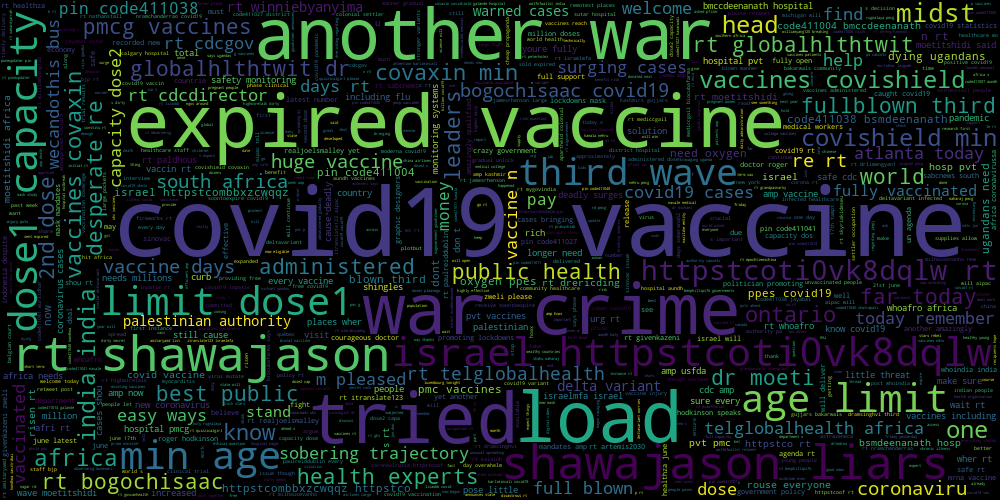

In [56]:
# world cloud visual of most common words

text = ','.join(list(tweets_data['original_text'].values))
wordcloud = WordCloud(width = 1000, height = 500, max_words=800, contour_width=8) # create word cloud object
wordcloud.generate(text)  # generate word cloud
wordcloud.to_image()

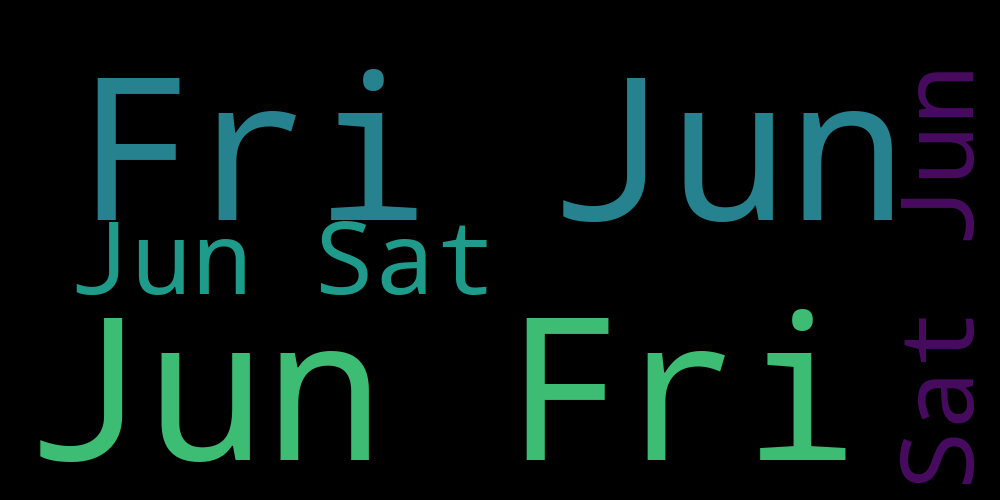

In [58]:
text = ','.join(list(tweets_df['created_at'].values))
wordcloud = WordCloud(width = 1000, height = 500, max_words=800, contour_width=8) # create word cloud object
wordcloud.generate(text)  # generate word cloud
wordcloud.to_image()
